## Multimodal Approach: Combining Strengths

The system leverages two key aspects:

## Image Feature Extraction:

A pre-trained convolutional neural network (ResNet50) extracts features from product images, capturing their visual characteristics (colors, patterns, styles).

## Text Feature Extraction:

Natural language processing (NLP) techniques are used to analyze product descriptions. Here, the code explores two approaches:

* TF-IDF: This method transforms textual descriptions into numerical vectors, highlighting the importance of words within the product category.
* BERT Embeddings: This method utilizes a pre-trained BERT model to capture deeper semantic relationships within product descriptions, going beyond simple word frequency.

By combining these extracted features, the system creates a comprehensive representation of each product, encompassing both visual and textual information.

## Case Study: Striped Polo Shirt Recommendations

In the provided example, the model is presented with a striped polo shirt. Here's how the recommendation process unfolds:

## Feature Extraction:

The system analyzes the product image using ResNet50, extracting features that represent the shirt's visual properties, such as the presence of stripes and the overall style.

## Text Analysis:

The NLP techniques are applied to the product description (which might mention "striped polo shirt"). TF-IDF or BERT embeddings are generated, capturing the textual aspects of the product.

## Similarity Matching:

The combined features (image and text) for the striped polo shirt are compared with the combined features of all other products in the dataset using cosine similarity. This metric identifies products with the most similar features to the selected one.

## Recommendation Display:

The system recommends the top few products with the highest cosine similarity scores. In this case, these recommendations would likely be other striped polo shirts or visually similar tops, demonstrating the model's ability to suggest relevant items based on the selected product.


# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

# Data Preparation

In [ ]:
import pathlib
import os

path = '../input/fashion-product-images-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']

In [ ]:
def preprocessText(text):
    if isinstance(text, str):
        stop_words = set(stopwords.words('english'))
        words = nltk.word_tokenize(text)
        filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        return ' '.join(filtered_words)
    else:
        return ''

In [ ]:
import numpy as np
import pandas as pd
garment_data = pd.read_csv(path + "styles.csv", nrows=6000) # Read 6000 products and drop bad lines 
garment_data['image'] = garment_data.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Create image column containing (id.jpg)
print(garment_data.shape)
garment_data.head(5)


(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


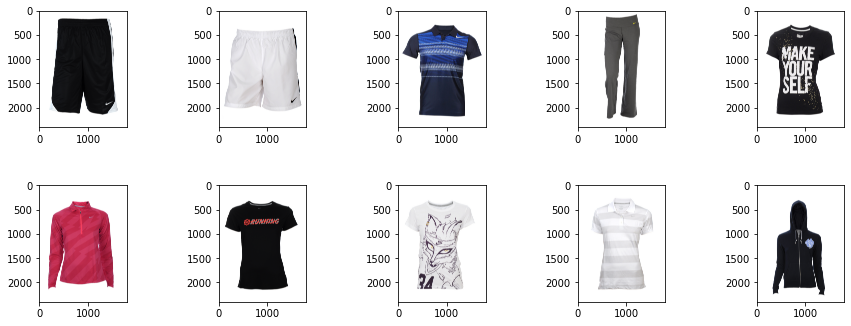

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot samples 
plt.figure(figsize=(15,15))  # Adjusting the figure size
for idx in range(20,30):
    plt.subplot(5, 5, idx-19)  # Changing the subplot size
    garment_pic =  mpimg.imread(path + 'images/100' + str(idx) +'.jpg')  # Assigning image ids
    plt.imshow(garment_pic)
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjusting the space between subplots
plt.show()


<AxesSubplot:>

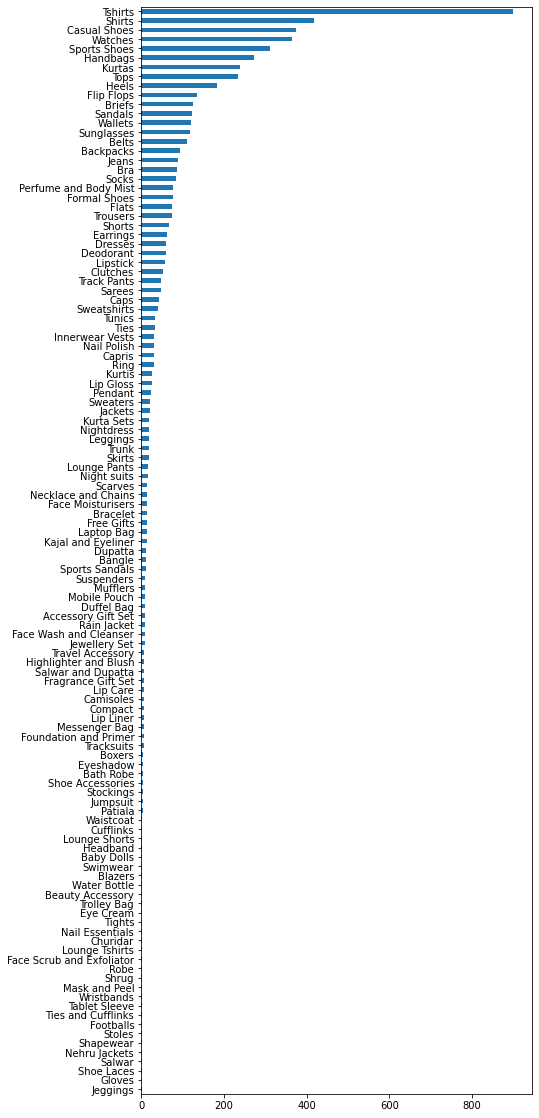

In [ ]:
plt.figure(figsize=(7,20))  # Adjusting the figure size
garment_data.articleType.value_counts().sort_values().plot(kind='barh')  # Plotting articleType counts


# Modeling and Get Image Embeddings

In [ ]:
img_width, img_height, chnls = 100, 100, 3

# USING RESNET50 

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
resnet.trainable = False
resnet_model = keras.Sequential([resnet, GlobalMaxPooling2D()])
resnet_model.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
def full_image_path(image_name):
    """Take image name(id) and return the complete path of it"""
    return path + 'images/' + image_name

def make_prediction_with_model(model, image_name):
    """Load and preprocess image then make prediction"""
    # Reshape
    img = image.load_img(full_image_path(image_name), target_size=(img_width, img_height))
    # Convert image to array
    img_array = image.img_to_array(img)
    # Expand dimension to (1, w, h, c)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess input
    img_array = preprocess_input(img_array)
    # Make prediction
    return model.predict(img_array)


In [ ]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + 'images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
#     img = image.load_img(os.path.join(path, "images", img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

# Extracting Image Features

In [ ]:
def extract_features(data_frame, neural_net_model):
    """Return a dataframe containing image features"""
    df_copy = data_frame.copy()
    df_features = df_copy['image'].apply(lambda x: make_prediction_with_model(neural_net_model, x).reshape(-1))
    df_features = df_features.apply(pd.Series)
    return df_features

df_features = extract_features(garment_data, resnet_model)


In [ ]:
df_features.to_csv("/kaggle/working/df_embeddings.csv", index=False)

In [ ]:
df_features.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.510166,0.000000,6.348346,3.223025,0.0,0.0,0.000000,10.025206,0.201878,...,0.0,0.0,2.253910,0.0,0.964793,0.000000,0.0,7.196214,3.491305,2.378204
1,0.0,1.764585,0.000000,5.119553,1.700444,0.0,0.0,0.000000,2.795278,0.000000,...,0.0,0.0,0.274061,0.0,0.000000,0.135836,0.0,8.407726,7.632229,1.322279
2,0.0,1.588556,0.513117,4.632957,2.526207,0.0,0.0,0.207656,4.223385,0.954324,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,10.367856,4.302145,1.301307
3,0.0,1.376686,0.000000,4.452281,3.188160,0.0,0.0,0.000000,5.797526,0.092486,...,0.0,0.0,0.000000,0.0,0.000324,3.220960,0.0,6.535896,4.232082,1.022344
4,0.0,1.011487,0.838248,4.282856,0.212705,0.0,0.0,0.000000,8.638965,0.000000,...,0.0,0.0,1.431373,0.0,0.000000,0.000000,0.0,4.674869,5.368521,0.000000


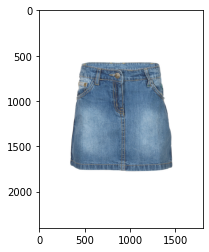

In [ ]:
url="../input/fashion-product-images-dataset/fashion-dataset/images/10001.jpg"
a = plt.imread(url)
plt.imshow(a)

In [ ]:
sample_image = make_prediction_with_model(resnet_model, '10001.jpg')
sample_image.shape

(1, 2048)

In [ ]:
df_sample_image = pd.DataFrame(sample_image)  
print(df_sample_image)

   0         1         2     3         4     5     6     7         8     9     \
0   0.0  3.721795  3.915592   0.0  4.355661   0.0   0.0   0.0  1.055705   0.0   

   ...      2038      2039      2040  2041  2042  2043  2044      2045  \
0  ...  2.267267  0.193102  3.365073   0.0   0.0   0.0   0.0  6.292594   

       2046      2047  
0  7.063136  2.775618  

[1 rows x 2048 columns]


# Recommendations Based on feature similarity 

In [ ]:
sample_similarity = linear_kernel(df_sample_image, df_features)
print(sample_similarity)

[[ 9223.678   7980.8003  9323.818  ...  9116.562   9339.691  10493.376 ]]


In [ ]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(resnet_model, '10004.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_features)
    return sample_similarity

In [ ]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

# using linear kernel

In [ ]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

# Recommendation Based on images only

[(198, 1.0), (5574, 0.9795892), (5815, 0.956232), (1387, 0.9489281), (4508, 0.948823)]


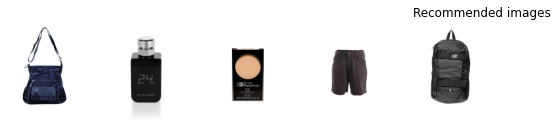

In [ ]:
recommendation = get_recommendations(garment_data, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# Text Feature Extraction

In [ ]:
styles_df = pd.read_csv(path + "styles.csv", nrows=6000) # Read 6000 products and drop bad lines 


In [ ]:
def preprocessText(text):
    if isinstance(text, str):
        stop_words = set(stopwords.words('english'))
        words = nltk.word_tokenize(text)
        filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        return ' '.join(filtered_words)
    else:
        return ''

In [ ]:
def extractTextFeatures(text, vectorizer):
     return vectorizer.transform([text]).toarray().flatten()

In [ ]:
styles_df['cleaned_text'] = styles_df['productDisplayName'].apply(preprocessText)

In [ ]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,cleaned_text
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,turtle check men navy blue shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,peter england men party blue jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,titan women silver watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,manchester united men solid black track pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,puma men grey


using TF-IDF to conver them into vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(styles_df['cleaned_text'])

In [ ]:
tfidf_matrix

<6000x2393 sparse matrix of type '<class 'numpy.float64'>'
	with 31933 stored elements in Compressed Sparse Row format>

concatenating the products

In [ ]:
# Concatenate text and image embeddings
combined_features = np.concatenate([tfidf_matrix.toarray(), df_features], axis=1)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between the sample product and all other products
sample_similarity = cosine_similarity(combined_features, combined_features)

# Get indices of top similar products (excluding the sample product itself)
top_indices = np.argsort(sample_similarity[-1])[::-1][1:6]

# Get recommended product IDs
recommended_product_ids = styles_df.iloc[top_indices]['id']

# Display recommended product IDs
print("Recommended Product IDs:", recommended_product_ids)

Recommended Product IDs: 273     18698
3951    18699
4137    10400
988     45632
3735    52222
Name: id, dtype: int64


In [ ]:
product_details = styles_df[styles_df['id'] == 17417]
print(product_details)

         id gender masterCategory subCategory articleType baseColour  season  \
4160  17417    Men    Accessories     Watches     Watches      Black  Winter   

      year   usage                                productDisplayName  \
4160  2016  Casual  CASIO ENTICER Men Black Dial Analogue Watch A416   

                                     cleaned_text      image  
4160  casio enticer men black dial analogue watch  17417.jpg  


In [ ]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,cleaned_text
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,turtle check men navy blue shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,peter england men party blue jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,titan women silver watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,manchester united men solid black track pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,puma men grey


In [ ]:
import numpy as np
import pandas as pd
garment_data = pd.read_csv(path + "styles.csv", nrows=6000) # Read 6000 products and drop bad lines 
garment_data['image'] = garment_data.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Create image column containing (id.jpg)
print(garment_data.shape)
garment_data.head(5)


In [ ]:
import pandas as pd


# Check if an 'image' column already exists (avoid duplicates)
if 'image' not in styles_df.columns:
  # Create a new 'image' column using a lambda function
  styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)

print(styles_df.tail())


         id  gender masterCategory subCategory   articleType baseColour  \
5995  59523   Women    Accessories   Jewellery      Earrings     Silver   
5996  53019   Women        Apparel       Saree        Sarees      Green   
5997   5389  Unisex       Footwear       Shoes  Sports Shoes     Yellow   
5998  24977     Men        Apparel     Topwear       Tshirts       Pink   
5999  45940     Men    Accessories     Watches       Watches      Black   

      season  year   usage                                 productDisplayName  \
5995  Summer  2015  Casual                             Lucera Silver Earrings   
5996    Fall  2012  Ethnic                                     FNF Green Sari   
5997     NaN  2011  Sports                     Kalenji Kapteren 200 Yellow Fw   
5998  Summer  2012  Casual  United Colors of Benetton Men Pink Printed T-s...   
5999  Winter  2016  Casual                        Maxima Men Black Dial Watch   

                                 cleaned_text      image  
599

# Recommendation based on the similarity using the concept of multimodal

In [55]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Assume you have a DataFrame named styles_df and it has an 'id' column

# Select a random sample product ID
random_index = random.randint(0, len(styles_df) - 1)
sample_product_id = styles_df.iloc[random_index]['id']

# Display the sample product details
print("Sample Product Details:")
print(styles_df.loc[styles_df['id'] == sample_product_id])

# Calculate cosine similarity between the sample product and all other products
sample_index = styles_df.index[styles_df['id'] == sample_product_id].tolist()[0]
sample_similarity = cosine_similarity(combined_features, combined_features)

# Get indices of top similar products (excluding the sample product itself)
top_indices = np.argsort(sample_similarity[sample_index])[::-1][1:6]

# Get recommended product IDs, images, and names
recommended_product_ids = styles_df.iloc[top_indices]['id']
recommended_product_images = styles_df.iloc[top_indices]['image']
recommended_product_names = styles_df.iloc[top_indices]['productDisplayName']

# Display recommended product IDs, names, and images
plt.figure(figsize=(45, 5))
for i, (product_id, product_image, product_name) in enumerate(zip(recommended_product_ids, recommended_product_images, recommended_product_names)):
    img_path = os.path.join('path/to/images', product_image)  # Update this path
    try:
        img = mpimg.imread(img_path)
        plt.subplot(1, 6, i+1)
        plt.imshow(img)
        plt.title(f'ID: {product_id}\n{product_name}')  # Show product ID and name in title
        plt.axis('off')
    except FileNotFoundError:
        print(f"Image file not found for product ID: {product_id}")
plt.show()


Sample Product Details:
        id gender masterCategory subCategory articleType baseColour season  \
4704  7909    Men        Apparel     Topwear     Tshirts  Navy Blue   Fall   

      year   usage                             productDisplayName  \
4704  2011  Casual  Proline Men Navy & Cream Striped Polo T-shirt   

                             cleaned_text     image  
4704  proline men navy cream striped polo  7909.jpg  
Image file not found for product ID: 33285
Image file not found for product ID: 13426
Image file not found for product ID: 22334
Image file not found for product ID: 5891
Image file not found for product ID: 19583


<Figure size 3240x360 with 0 Axes>

here our model is recommedning based on the selected which is a striped polo tshirt and our model suggests products which are similar to that, here it has recommended product similar to striped polo tshirts

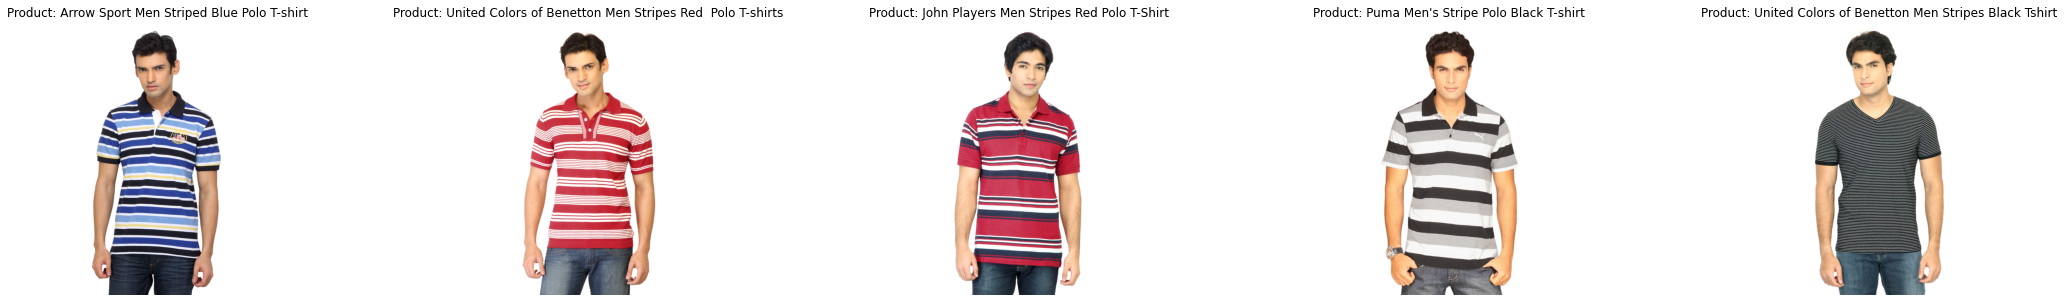

In [ ]:
# Get recommended product IDs and images
recommended_product_ids = styles_df.iloc[top_indices]['id']
recommended_product_images = styles_df.iloc[top_indices]['image']
recommended_product_names = styles_df.iloc[top_indices]['productDisplayName']

# Display recommended product IDs, names, and images
plt.figure(figsize=(45, 5))
for i, (product_id, product_image, product_name) in enumerate(zip(recommended_product_ids, recommended_product_images, recommended_product_names)):
    plt.subplot(1, 6, i+1)
    img = mpimg.imread(path + 'images/' + product_image)
    plt.imshow(img)
    plt.title(f'Product: {product_name}')  # Add product name to title
    plt.axis('off')
plt.show()

# Conclusion

This code implements a multimodal recommender system for fashion products, combining image and text features to suggest similar items. In the example, the model recommends products visually similar to a chosen striped polo shirt, demonstrating its ability to capture both visual and textual cues for recommendations.

# I have tried using bert but i was facing some issues with hugging face so i decided to go for regular text preprocessing and extraction

In [21]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [22]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer
import torch

In [37]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [38]:
# Define function for text preprocessing using BERT
def preprocess_text_with_bert(text):
    # Tokenize text using BERT tokenizer
    tokens = tokenizer.tokenize(text)
    
    # Remove stopwords (BERT tokenizer doesn't handle this)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Lemmatize tokens (BERT tokenizer doesn't handle this)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Convert tokens to torch tensor
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    tokens_tensor = torch.tensor(input_ids)
    
    return tokens_tensor

In [39]:
# Convert values in 'productDisplayName' column to strings
garment_data['productDisplayName'] = garment_data['productDisplayName'].astype(str)


In [40]:
garment_data['productDisplayName'].dtype

dtype('O')

In [41]:
# Apply preprocessing to the productDisplayName column
garment_data['preprocessed_productDisplayName'] = garment_data['productDisplayName'].apply(preprocess_text_with_bert)

# Print the first few rows of the DataFrame to verify preprocessing
print(garment_data[['productDisplayName', 'preprocessed_productDisplayName']].head())

                              productDisplayName  \
0               Turtle Check Men Navy Blue Shirt   
1             Peter England Men Party Blue Jeans   
2                       Titan Women Silver Watch   
3  Manchester United Men Solid Black Track Pants   
4                          Puma Men Grey T-shirt   

                     preprocessed_productDisplayName  
0  [tensor(13170), tensor(4638), tensor(2273), te...  
1  [tensor(2848), tensor(2563), tensor(2273), ten...  
2  [tensor(16537), tensor(2450), tensor(3165), te...  
3  [tensor(5087), tensor(2142), tensor(2273), ten...  
4  [tensor(16405), tensor(2863), tensor(2273), te...  


In [42]:
import numpy as np
import torch
from transformers import BertModel, BertTokenizer

In [43]:


# Initialize BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to extract features using BERT embeddings
def extract_bert_features(text):
    # Tokenize text
    tokens = tokenizer.tokenize(text)
    
    # Convert tokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Convert input IDs to tensor
    input_ids_tensor = torch.tensor([input_ids])
    
    # Pass input IDs through BERT model
    with torch.no_grad():
        outputs = bert_model(input_ids_tensor)
        bert_embeddings = outputs[0]
    
    # Calculate mean of embeddings
    mean_embedding = torch.mean(bert_embeddings, dim=1).squeeze().numpy()
    
    return mean_embedding

# Apply feature extraction using BERT embeddings
garment_data['bert_features'] = garment_data['productDisplayName'].apply(extract_bert_features)

# Print the first few rows of the DataFrame with BERT features
print(garment_data[['productDisplayName', 'bert_features']].head())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                              productDisplayName  \
0               Turtle Check Men Navy Blue Shirt   
1             Peter England Men Party Blue Jeans   
2                       Titan Women Silver Watch   
3  Manchester United Men Solid Black Track Pants   
4                          Puma Men Grey T-shirt   

                                       bert_features  
0  [0.39194474, 0.55196303, -0.3850365, -0.091902...  
1  [-0.008931637, 0.2900392, 0.36582828, 0.018922...  
2  [-0.4055371, 0.1751374, 0.56372356, -0.0962849...  
3  [0.0070389775, 0.6103963, 0.19688658, 0.209426...  
4  [1.0129766, 0.021067027, -0.11852442, 0.261223...  
